1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: pituitary, Confidence: 100.00%


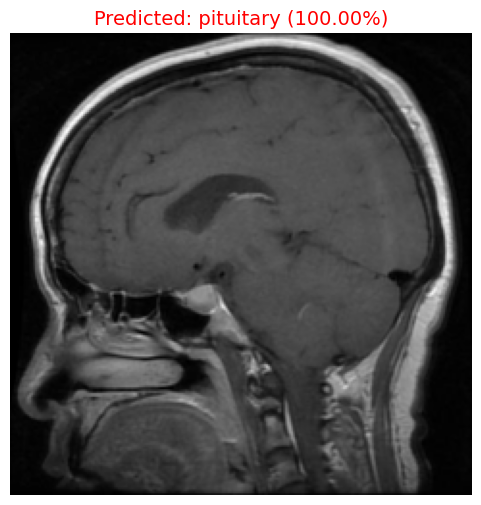

In [27]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

# Define class labels (must match training order)
class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Load the trained VGG16 model
model = tf.keras.models.load_model("./brain_tumor_ResNet_Full.h5")

def preprocess_image(image_path, target_size=(240, 240)):
    """
    Preprocess the input image to match the format used in training.
    """
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = Image.fromarray(img)  # Convert to PIL Image
    img = img.resize(target_size)  # Resize to (240,240) for ResNet

    img_original = np.array(img)  # Keep original for display

    img = np.array(img, dtype=np.float32)  # Convert to float
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Apply ResNet preprocessing (scaling, normalization)

    return img, img_original  # Return both processed and original image

# Path to test image
image_path = r"C:\Users\Shari\OneDrive - iut-dhaka.edu\7th Semester\Projects\Emon\archive\Testing\pituitary\Te-piTr_0003.jpg"
# Preprocess the image
processed_image, original_image = preprocess_image(image_path)

# Make prediction
probabilities = model.predict(processed_image)[0]  # Directly get softmax outputs

# Get predicted class and confidence
predicted_class_index = np.argmax(probabilities)  # Get highest probability index
predicted_class = class_names[predicted_class_index]  # Get class label
confidence = probabilities[predicted_class_index] * 100  # Convert to percentage

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")
# **🔹 Display image with prediction**
plt.figure(figsize=(6,6))
plt.imshow(original_image)  # Show original image
plt.axis('off')  # Hide axes
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)", fontsize=14, color='red')
plt.show()

#model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
<Conv2D name=conv5_block3_3_conv, built=True>
[[ 5.16807463e-13  5.16807463e-13  5.16807463e-13  5.16807463e-13
   5.16807463e-13  5.16807463e-13  5.16807463e-13  5.16807463e-13
   5.16807463e-13  5.16807463e-13  5.16807463e-13  5.16807463e-13
   5.16807463e-13  5.16807463e-13  5.16807463e-13  5.13983712e-13
   5.08336157e-13  5.02688603e-13  4.97041048e-13  4.91393547e-13
   4.85745992e-13  4.80098437e-13  4.74450882e-13  4.68803327e-13
   4.63155827e-13  4.57508272e-13  4.51860717e-13  4.46213189e-13
   4.40565634e-13  4.34918106e-13  4.29270551e-13  4.23623024e-13
   4.17975469e-13  4.12327941e-13  4.06680386e-13  4.01032858e-13
   3.95385303e-13  3.89737775e-13  3.84090221e-13  3.78442666e-13
   3.72795138e-13  3.67147583e-13  3.61500055e-13  3.55852500e-13
   3.50204972e-13  3.47017174e-13  3.46289159e-13  3.45561118e-13
   3.44833103e-13  3.44105061e-13  3.43377047e-13  3.42649005e-13
   3.41920990e-13  3.41192976e-13  3.40464934e-13  3.3973

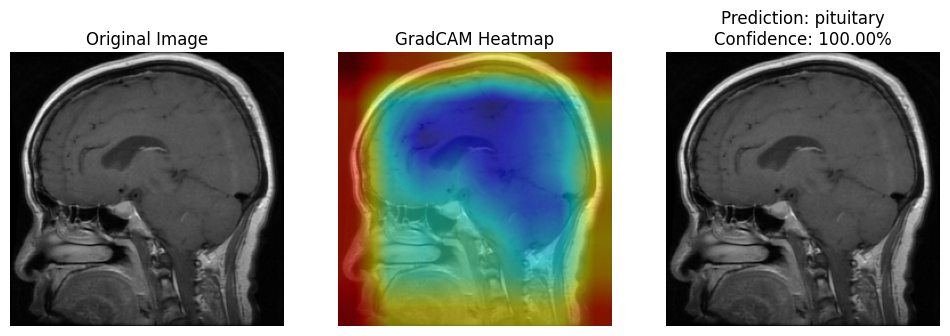

In [28]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import sys

np.set_printoptions(threshold=sys.maxsize)


def GradCAM2(model, image, interpolant=0.5, plot_results=True):
    assert (0 < interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    original_img = np.asarray(image, dtype=np.float32)
    test_image = image
    test_image_input = np.expand_dims(test_image, axis=0)
    image = preprocess_input(test_image_input)
    prediction = model.predict(image)
    prediction_idx = np.argmax(prediction)
    labels = ['notumor', 'glioma', 'meningioma', 'pituitary']
    predicted_label = labels[prediction_idx]
    confidence = prediction[0][prediction_idx] * 100

    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)
    print(target_layer)

    with tf.GradientTape() as tape:
        gradient_model = tf.keras.models.Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(image)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    
    #print(activation_map)

    activation_map = cv2.resize(activation_map.numpy(), (240, 240))

    print(activation_map)

    #activation_map = np.maximum(activation_map, 0)
    #activation_map = np.abs(activation_map)
    

    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = cv2.resize(cvt_heatmap, (240, 240))
    overlay = np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))

    if plot_results:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(original_img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(overlay)
        axes[1].set_title("GradCAM Heatmap")
        axes[1].axis("off")
        
        axes[2].imshow(original_img)
        axes[2].set_title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%")
        axes[2].axis("off")

        
        plt.show()
    else:
        return overlay

# Load a test image
#test_image_path = "/kaggle/input/Testing/glioma/Te-gl_0017.jpg"
pt = cv2.imread(image_path)
pt = cv2.resize(pt, (240, 240))

GradCAM2(model, pt, plot_results=True)